---
title: "Ollama for LLMs on your laptop, Introduction to Seurat, and scRNA-seq preprocessing"
author: "Samuele Soraggi"
image: ../img/news/SeuratV5.png
date: 2025-01-16
categories: [scrna, seurat, R]
description: "learn about seurat object structure and preprocessing of scrnaSeq data"
eval: false
---

# Slides

Today's slides with topic presentation about local language models with Ollama (from Manuel). 

&nbsp;

<p align="center">

<a href="https://abc.au.dk/documentation/slides/20250116-ABC11.zip" style="background-color: #4266A1; color: #FFFFFF; padding: 30px 20px; text-decoration: none; border-radius: 5px;"> Download Slides </a>

</p>

&nbsp;

# Tutorial

In this tutorial, we use of the Seurat package for single-cell RNA sequencing (scRNA-seq) data analysis. We cover

- **Data Structure**: Loading and exploring the scRNA-seq data, with a focus on the Seurat object structure.
- **Preprocessing**: Filtering low-quality cells and genes, Normalizing the data, identifying highly variable features, and scaling the data.
- **Clustering**: Performing dimensionality reduction (PCA), finding clusters, and visualizing the results using UMAP

This is just a small workflow to get you started with Seurat!

:::{.callout-warning}
You should be able to run the tutorial using these three packages: `tidyverse, Seurat, patchwork`
:::
Download the data ad unzip it

In [2]:
download.file("https://zenodo.org/records/11519797/files/Data.zip?download=1", destfile = "Data.zip")

In [3]:
system("unzip Data.zip && rm -rf Data.zip __MACOSX")

Load the necessary libraries and read in the data matrix

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)

sample <- Read10X(data.dir = "Data/cellranger_sample2/outs/filtered_feature_bc_matrix/")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




The data is now made into a Seurat Object. The count matrix is the one we just loaded, and we give the data a project name, which is the biological process we are studying. It can be some other name of course.

In [2]:
sample <- CreateSeuratObject(counts = sample, project = "spermatogenesis")

## The seurat object

The Seurat object is a list that contains all the information and calculated results about the single-cell experiment. It contains the following slots:

In [4]:
slotNames(sample)

[1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"

| Slot | Function |
| ---- | -------- |
| `assays` | A list of assays within this object, such as RNAseq |
| `meta.data` | Contains cell-level meta data |
| `active.assay` | Name of active, or default, assay |
| `active.ident` | Identity classes for the current object |
| `reductions` | A list of DimReduc objects, like PCA or UMAP |
| `project.name` | User-defined project name (optional) |

You can always look at any slot using the @ operator. For example, look at what assays are in the object:


In [5]:
sample@assays

$RNA
Assay (v5) data with 36601 features for 8583 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 
Layers:
 counts 


There is so far only one assay, with the name `RNA`. This is the **default assay** at the beginning of an analysys, and it contains the count matrix only at this time. Each matrix contained in the assay is called a **Layer**, and you can see there is only `counts`.

Other layers (matrices) that are added during an analysis are in the table below. An assay can also contain `meta.features`, which is a metadata table related to each gene (e.g. gene symbols, biotypes, gene ontology, ...).



In [7]:
sample@assays$RNA

Assay (v5) data with 36601 features for 8583 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 
Layers:
 counts 

| Layer | Function |
| ---- | -------- |
| `counts` | Stores unnormalized data such as raw counts or TPMs |
| `data` | Normalized data matrix |
| `scale.data` | Scaled data matrix |
| `meta.features` | Feature-level meta data |

You can use the command below to access a specific layer inside the assay which is currently active in the dataset.

In [8]:
GetAssayData(object = sample, layer ="counts")[1:10,1:10]

  [[ suppressing 10 column names ‘AAACCTGAGATCCTGT-1’, ‘AAACCTGAGCCTATGT-1’, ‘AAACCTGAGCTTTGGT-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                               
MIR1302-2HG . . . . . . . . . .
FAM138A     . . . . . . . . . .
OR4F5       . . . . . . . . . .
AL627309.1  . . . . . . 1 . . .
AL627309.3  . . . . . . . . . .
AL627309.2  . . . . . . . . . .
AL627309.5  . . . . . . . . . .
AL627309.4  . . . . . . . . . .
AP006222.2  . . . . . . . . . .
AL732372.1  . . . . . . . . . .

To see the assay currently active (which means used in the analysis), you can access the slot `active.assay`:

In [10]:
sample@active.assay

[1] "RNA"

:::{.callout-tip}
Usually, the default assay changes automatically after performing a normalization, so you do not need to do things manually like this. But it is good to know how to access the slots in the Seurat object to verify the data used.
:::

### Metadata

Another important assay is the `meta.data` slot, which contains cell-level metadata. This is where you can store information about each cell, such as cell type, cell cycle phase, or any other information you have about the cells.
For example, we add below the percentage of mitochondrial genes in each cell. This is a common quality control metric, as **high percentages of mitochondrial genes can indicate poor-quality cells**.

In [12]:
sample[["percent.mt"]] <- PercentageFeatureSet(sample, pattern = "^MT-")

Again, you can access the metadata using the @ operator:

In [13]:
head(sample@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCTGAGATCCTGT-1,spermatogenesis,694,473,5.04322767
AAACCTGAGCCTATGT-1,spermatogenesis,6868,2016,0.04368084
AAACCTGAGCTTTGGT-1,spermatogenesis,9188,3670,2.18763605
AAACCTGAGGATGGTC-1,spermatogenesis,4021,2175,0.00000000
AAACCTGAGTACGACG-1,spermatogenesis,3237,1622,1.54464010
AAACCTGAGTACGCCC-1,spermatogenesis,10213,3253,0.29374327


## Filtering

We filter out cells with low quality, such as cells with low gene counts or high mitochondrial gene content.

To have an idea of the distribution of those quality measures in each cell, we can plot them using the `VlnPlot` function. This function creates violin plots of the distribution of a given feature (e.g. gene counts, mitochondrial gene content) across all cells.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


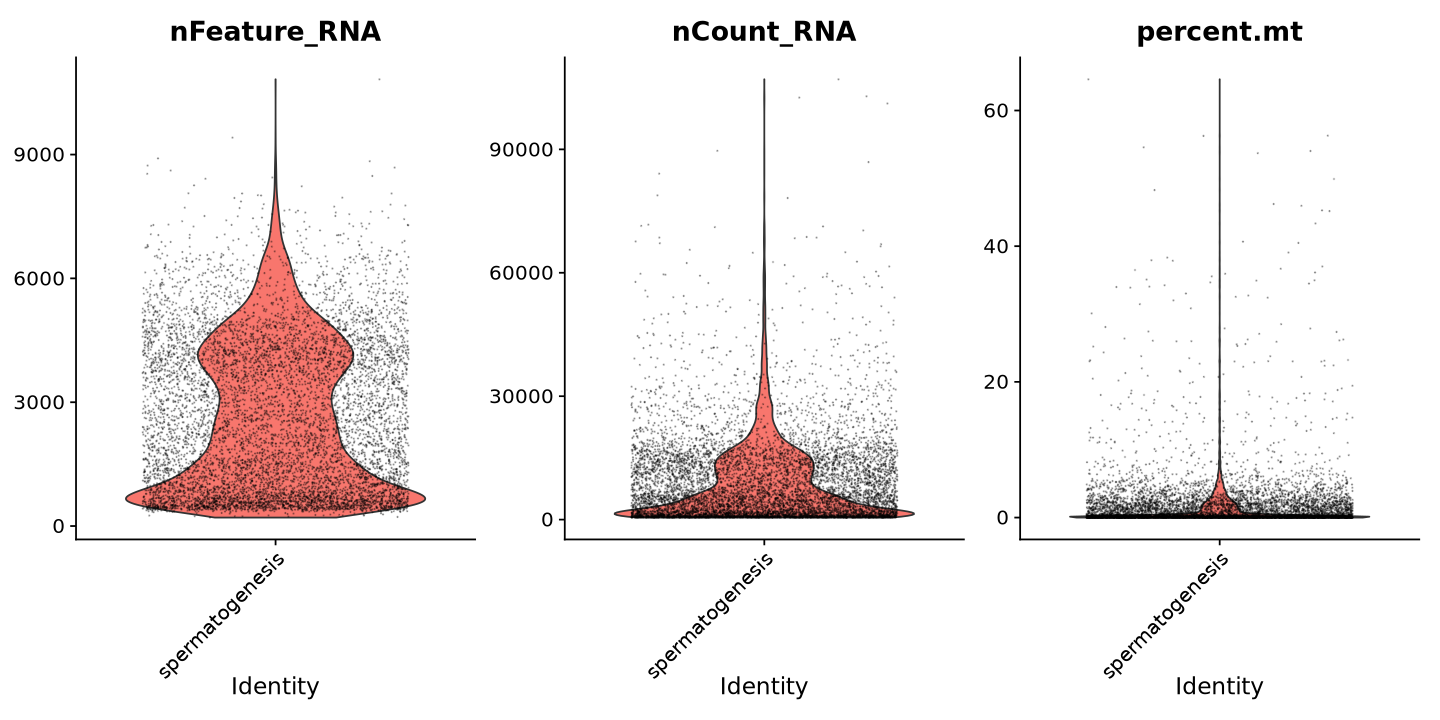

In [14]:
options(repr.plot.width = 12, repr.plot.height=6)
VlnPlot(sample, 
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        ncol = 3,
        alpha = .25)

Note how there are some cells with very few features (detected genes with at least one transcript) and very few counts (total transcripts associated to a gene). These cells are likely to be low-quality, or empty droplets with contamination, and should be removed from the analysis. The same for the cells with too many genes and transcripts, which are likely to be doublets (two cells captured in the same droplet).

Another useful plot is the one giving the relationship between number of transcripts and features in each cell. usually, those two measures grow together. If not, it can be a sign of low-quality cells. We can also notice a few outliers with huge amount of transcripts, but not always as many features. These are likely to be doublets.

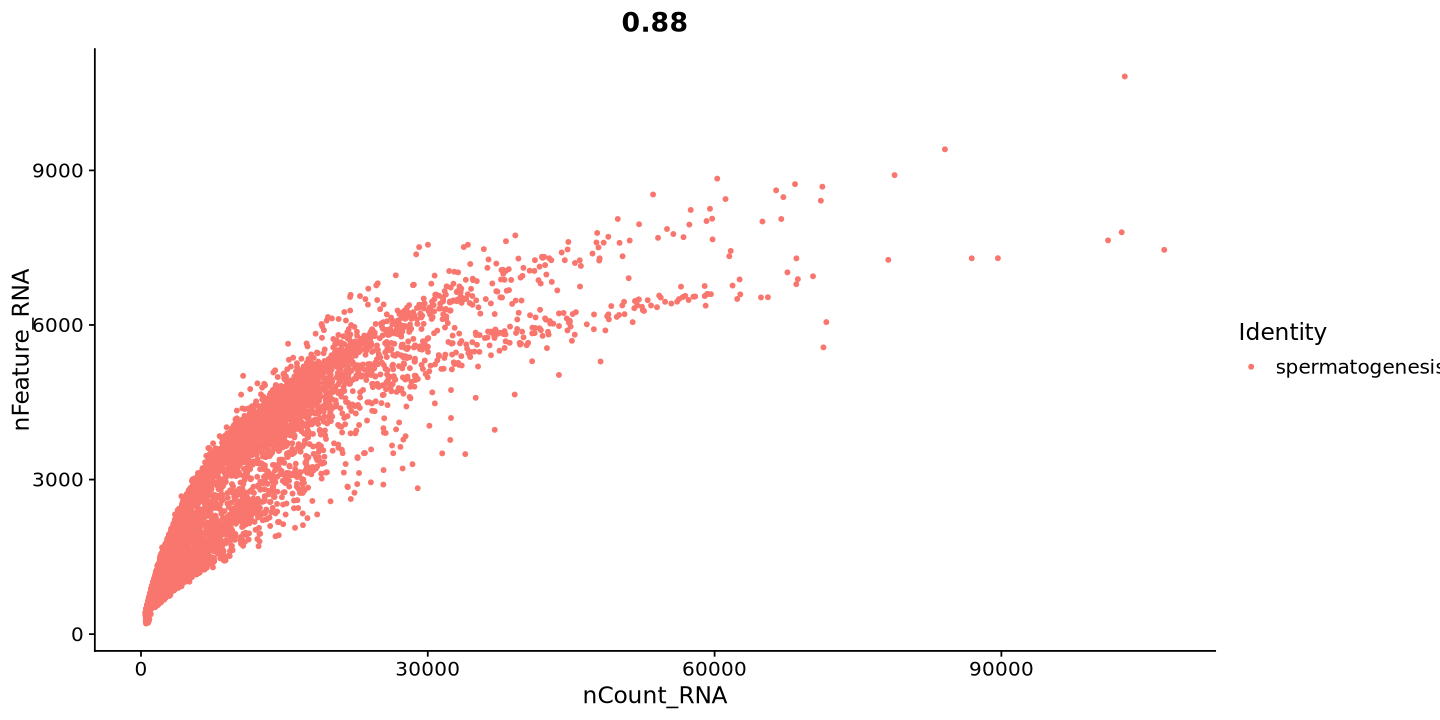

In [15]:
FeatureScatter(sample, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") 

Now we can choose the thresholds for filtering. We will remove cells with less than 2000 genes and more than 6000 genes, counts below 5000 and above 30000, and more than 10% mitochondrial genes.

In [16]:
MIN_COUNT = 5000  #minimum number of transcripts per cell
MAX_COUNT = 30000 #maximum number of transcripts per cell
MIN_GENES = 2000   #minimum number of genes per cell
MAX_GENES = 6000   #maximum number of genes per cell
MAX_MITO = 10      #mitocondrial percentage treshold)

sample <- subset( sample, 
                  subset = nFeature_RNA > MIN_GENES & 
                           nFeature_RNA < MAX_GENES &
                           nCount_RNA > MIN_COUNT & 
                           nCount_RNA < MAX_COUNT &
                           percent.mt < MAX_MITO )

Now the violin plot looks more uniform without a huge bottom peak, which is a good sign.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


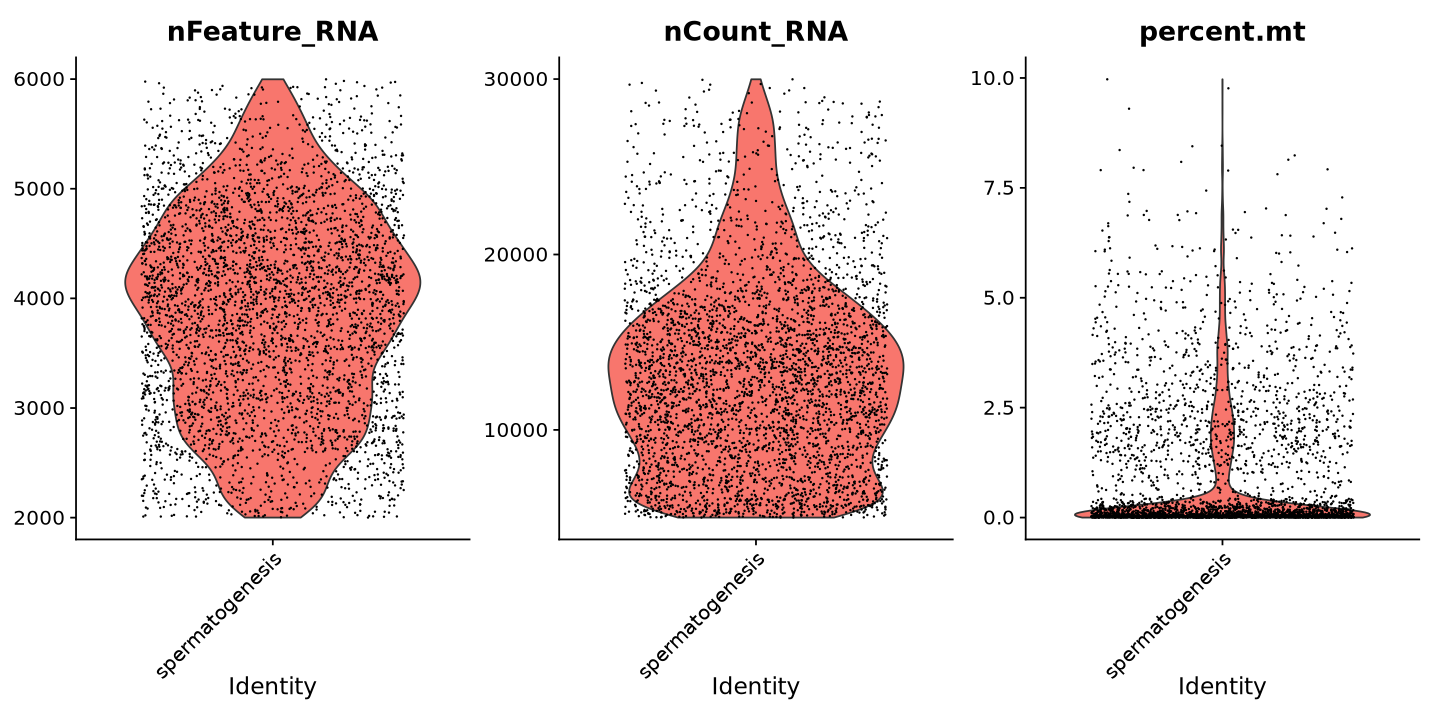

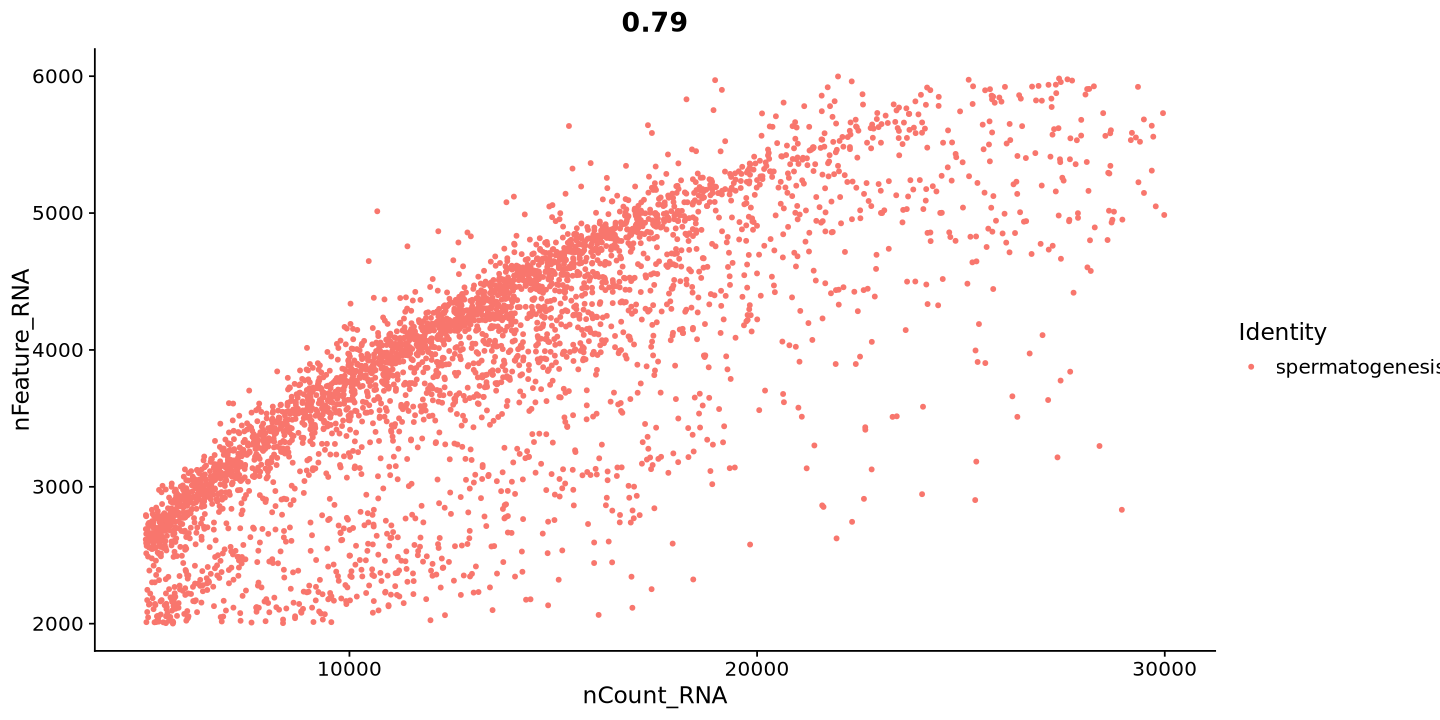

In [17]:
VlnPlot(sample, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
FeatureScatter(sample, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") 

## Normalization I

Normalization is the process of removing technical biases from the data. The most common normalization method is the **LogNormalize** method, which normalizes the data by the total expression, multiplies by a scale factor (10,000 by default), and log-transforms the result. This is done by `NormalizeData`. Usually the data is scaled using `ScaleData` to have a mean of 0 and a variance of 1.

In [18]:
sample <- NormalizeData(sample, normalization.method = "LogNormalize")
sample <- ScaleData(sample)

Normalizing layer: counts

Centering and scaling data matrix



Now look at the `RNA` assay again. You can see that 
- `data` layer has been added, which contains the normalized data
- scale.data is the `data` layer scaled with `ScaleData`

In [20]:
sample@assays

$RNA
Assay (v5) data with 36601 features for 3883 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 
Layers:
 counts, data, scale.data 


:::{.callout-tip}
Why do you have default assays and not default layers? When you choose a specific assay, the various algorithms in Seurat will automatically choose the correct layer in the assay. If there is no layer with the correct data, Seurat will throw an error. For example PCA will not work if you do not have a `scale.data` layer in the assay. All those details are in general taken care of automatically, but you can always have @fig-object below as a reference for all the various assays and layers, and to which Seurat functions they are used.

![Structure of Seurat object, with the assays and functions connected to them in the Seurat package. Further assays and functions can exist if you use additional external packages.](2025-01-16-ABC11/SeuratObject.jpg){width=800px fig-align=center label=fig-object}
:::

## PCA and UMAP visualizations

Now we can plot a dimensionality reduction of our data. Usually, you look for the most variable genes, which are the most meaningful on a biological level. This is done with the ``FindVariableFeatures`` function. 


What does it do? This function calculates the mean and dispersion of each gene, and then selects the most variable genes based on a threshold. The default is to select the top 2000 most variable genes.

In [21]:
sample <- FindVariableFeatures(sample, nfeatures = 2000)

Finding variable features for layer counts



If you look at the assay, you can notice a small change, where it now shows the top variable features instead of the first ten in the expression matrix

In [22]:
sample@assays$RNA

Assay (v5) data with 36601 features for 3883 cells
Top 10 variable features:
 PTGDS, ACTA2, TMSB4X, TAGLN, B2M, S100A6, MYL9, MGP, DCN, KRT17 
Layers:
 counts, data, scale.data 

You can now run and print the PCA of the data, which will be based on the variable features. The PCA is a way to reduce the dimensionality of the data, and it is useful to visualize the data in 2D or 3D. The PCA is calculated using the `RunPCA` function.

:::{.callout-tip}
The first components are the most relevant to the data, and the PCA function prints the genes that influence the most each component. This is useful to understand what the components represent. For example, if one component has a long list of mitochondrial genes, it is likely to represent the mitochondrial content of the cells, which you might want to remove in the future analysis where it could cover for other biological factors that are relevant to you.
:::

PC_ 1 
Positive:  HMGB4, GTSF1L, ACTL7A, TSSK2, GAPDHS, SMCP, FHL5, NUPR2, SPTY2D1OS, CAPZA3 
	   H1FNT, C10orf82, FAM71E1, RNF151, C16orf82, ACTL9, IQCF1, C2orf88, FAM71F1, SPATA19 
	   CCDC196, GNG2, C9orf24, SPERT, CCDC91, CLPB, TSSK1B, TMCO2, LELP1, AC002463.1 
Negative:  HSP90AA1, NPM1, COX7A2L, MT-CO1, MT-ND2, PTGES3, MT-CO3, MT-ND1, MT-CO2, RPS17 
	   PARK7, MT-ATP6, CALM2, GABARAPL2, MT-ND4, BANF1, TRMT112, H2AFZ, CKS2, SNRPD1 
	   FTH1, RPS12, RPL21, HNRNPA3, EIF5, RBX1, MTX2, RPL18, SBNO1, BUD23 
PC_ 2 
Positive:  FTL, SOD1, NDUFA13, MIF, S100A11, S100A10, RPL10, FBL, ANXA2, CNN1 
	   RPS4Y1, LDHB, RPL36A, RPS21, PRDX1, GLUL, RBM3, RPL18A, CIRBP, RPL39 
	   RPS4X, EIF4E, SLC25A5, GPI, SLC25A6, RPL21, RPLP1, HSPB1, NME2, GSTP1 
Negative:  LDHC, SPINK2, TMEM225B, REXO5, CCDC110, ZPBP2, CCT6B, AL133499.1, ANKRD7, PPP3R2 
	   DYDC1, CETN1, PTTG1, SPAG6, CCDC42, CLGN, LINC01016, DBF4, PBK, ETFRF1 
	   MCHR2-AS1, TBPL1, SPATA22, PPP1R1C, CT66, C15orf61, TMPRSS12, KPNA5, AC002467.1,

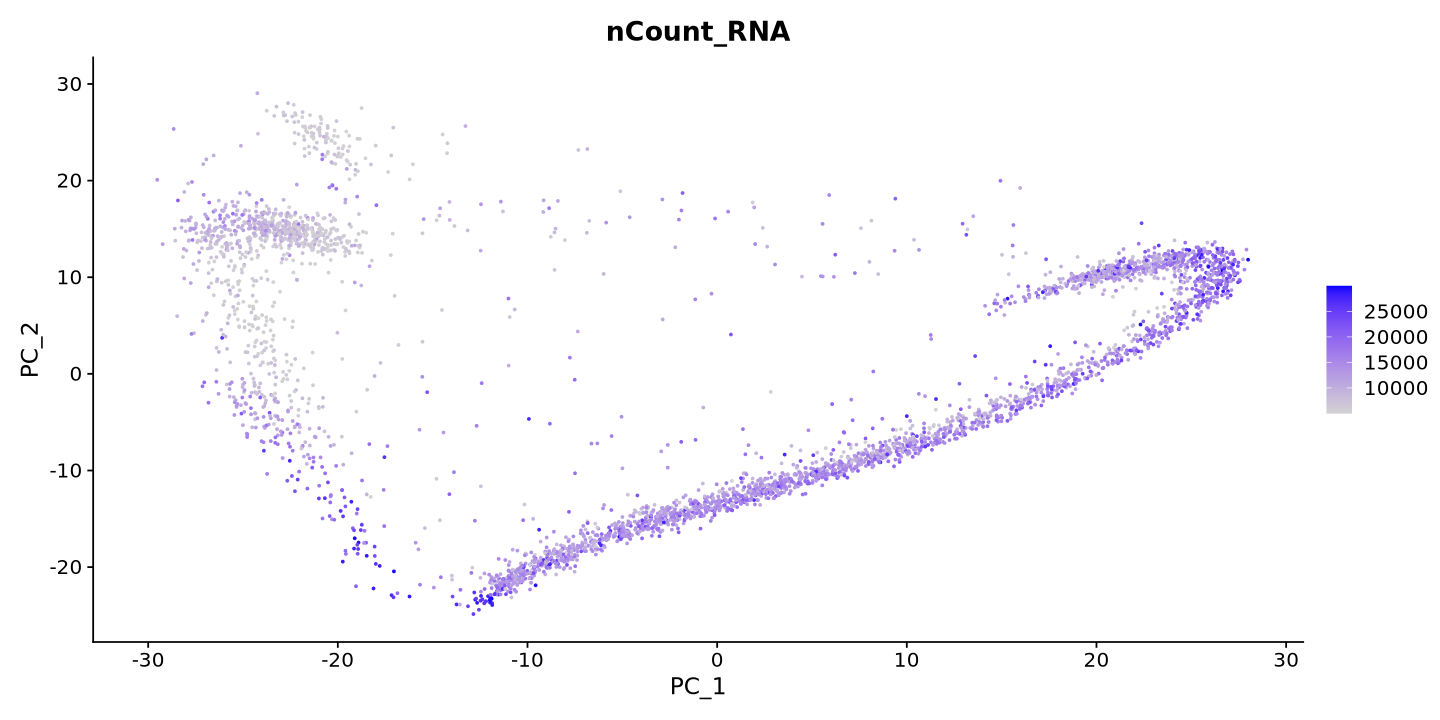

In [23]:
sample <- RunPCA(sample, features = VariableFeatures(object = sample))
FeaturePlot(sample, reduction = 'pca', features = "nCount_RNA")

The plot above is coloured by the number of transcripts in each cell. Each dot is a cell. You can see that the PCA separates the cells by the number of transcripts - This is because the number of transcripts is a technical factor, and the simple normalization we did before probably did not remove for its beffect on the data. 

Another thing to take into account is that the PCA is not the best way to visualize the data, as it is a linear transformation of the data. The UMAP is a non-linear transformation that is more suitable for single-cell data. You can run the UMAP using the `RunUMAP` function. But before, look at how much variance there is in each PCA component (plot below), and there choose a threshold where the value is low. Usually 10 to 15 is just fine.

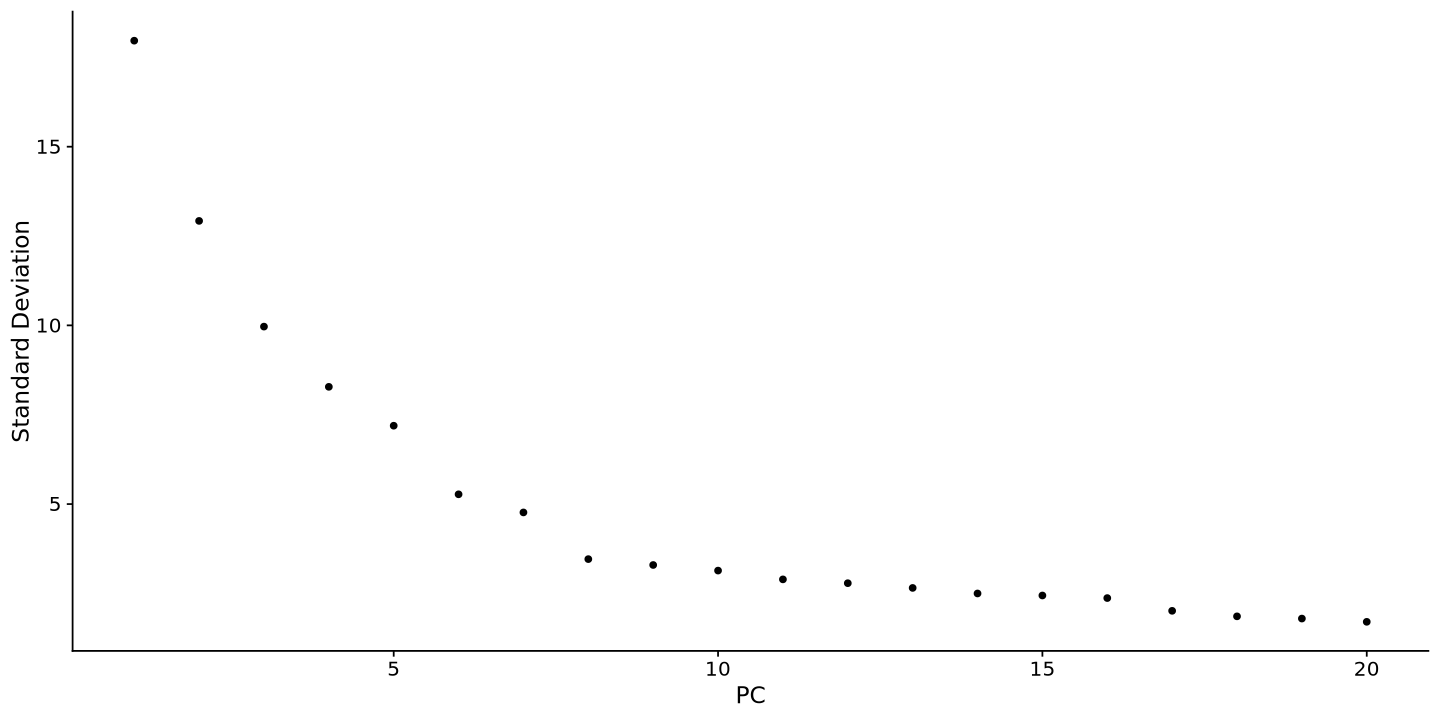

In [24]:
ElbowPlot(sample)

Then run the UMAP selecting the first ten dimensions of the PCA

In [25]:
sample <- RunUMAP(sample, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:58:33 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:33 Read 3883 rows and found 10 numeric columns

14:58:33 Using Annoy for neighbor search, n_neighbors = 30

14:58:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:33 Writing NN index file to temp file /tmp/RtmphwjaOt/file1efcb5fdb2ff7

14:58:33 Searching Annoy index using 1 thread, search_k = 3000

14:58:34 Annoy recall = 100%

14:58:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

Pretty! We can visualize some know markers, AKAP4 for maturing spermatozoa and PIWIL1 for meiosis. You can see that the cells are separated by the expression of these genes. This is a good sign that the clustering will work well, and that the UMAP represents biological variation. Since UMAP is based on PCA, the PCA was also a good representation of the data and not only biased by the number of transcripts as technical factor.

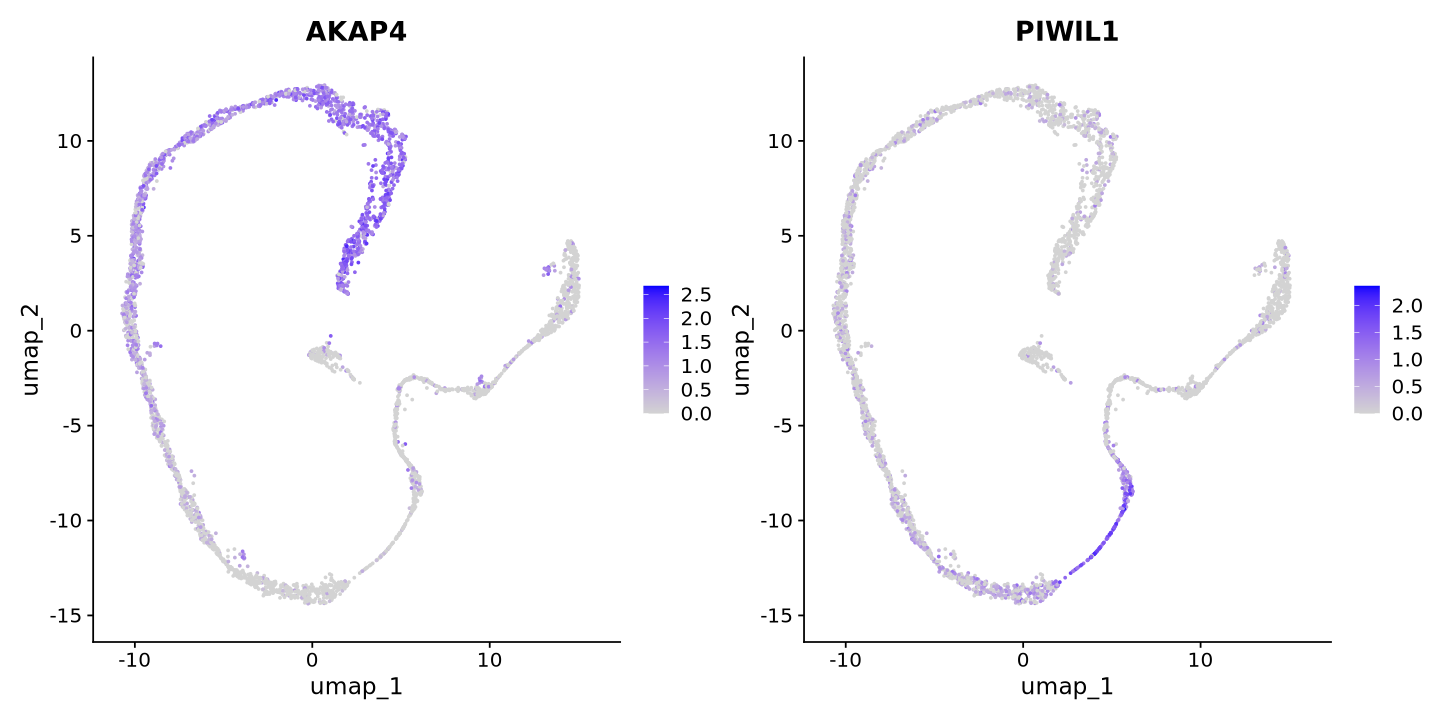

In [26]:
FeaturePlot(sample, reduction = "umap", features = c("AKAP4","PIWIL1"))

## Normalization II

Now, one might want a better normalization method. The one we used before is very simple and does not take into account the technical factors that can be present in the data. For example, we might have found out that the PCA was completely biased by cell cycle markers, and we want to remove this bias. This is done by the `SCTransform` function, which is a more advanced normalization method that takes into account technical factors in the data. Below we do not insert technical factors, but you can do it by adding them in the `vars.to.regress` argument. Try to remove the effect of mitochondrial content using `vars.to.regress = "percent.mito"` in the command below (we noticed after all some mitochondrial genes in the first PCA component). One can add also multiple factors, like `vars.to.regress = c("percent.mito", "cell.cycle")`.

In [27]:
sample <- SCTransform(sample)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 26386 by 3883

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3883 cells

Found 12 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 26386 genes

Computing corrected count matrix for 26386 genes

Calculating gene attributes

Wall clock passed: Time difference of 48.80969 secs

Determine variable features

Centering data matrix

Set default assay to SCT



Let's calculate PCA and UMAP again

In [28]:
sample <- RunPCA(sample, features = VariableFeatures(object = sample))

PC_ 1 
Positive:  MT-CO2, MT-ND4, MT-CO1, MT-CO3, MT-CYB, RPL21, PTMA, RPL18A, HIST1H4C, MT-ATP6 
	   MALAT1, MT-ND1, HSP90AA1, RPS2, GAGE2A, SMC3, RPSA, CCNI, RPLP1, BUD23 
	   FTH1, RPL10, DNAJB6, RPS12, RPS19, PRDX1, CIRBP, HMGB1, NCL, RNPS1 
Negative:  HMGB4, TNP1, PRM1, PRM2, LINC01921, CRISP2, SMCP, LINC00919, GTSF1L, LELP1 
	   RNF151, NUPR2, TSACC, C10orf62, TSSK2, GAPDHS, FAM209A, OAZ3, TEX37, CAPZA3 
	   CMTM2, FAM71A, AC002463.1, CATSPERZ, TEX38, C20orf141, FAM71B, TSPAN16, SH3RF2, IRGC 
PC_ 2 
Positive:  AL133499.1, LDHC, ANKRD7, SPATA8, SPINK2, LYAR, RBAKDN, SPATA22, CCDC42, COPRS 
	   ZMYND10, CAVIN3, CCNA1, GIHCG, PPP3R2, CLGN, GTF2A2, ZPBP2, REXO5, TBPL1 
	   MRPL34, H2AFJ, PTTG1, AC004817.2, TMEM225B, CATSPERZ, UBB, APH1B, COX7A2, CCDC110 
Negative:  PRM2, PRM1, TNP1, HMGB4, LINC01921, LINC00919, LELP1, GLUL, TEX37, FAM71B 
	   FAM71A, C10orf62, RNF151, OAZ3, HEMGN, C20orf141, NFKBIB, CEP170, PRSS58, TSPAN16 
	   SPATA42, RPL18A, SH3RF2, TEX44, AC002463.1, IQCF2, OTUB2

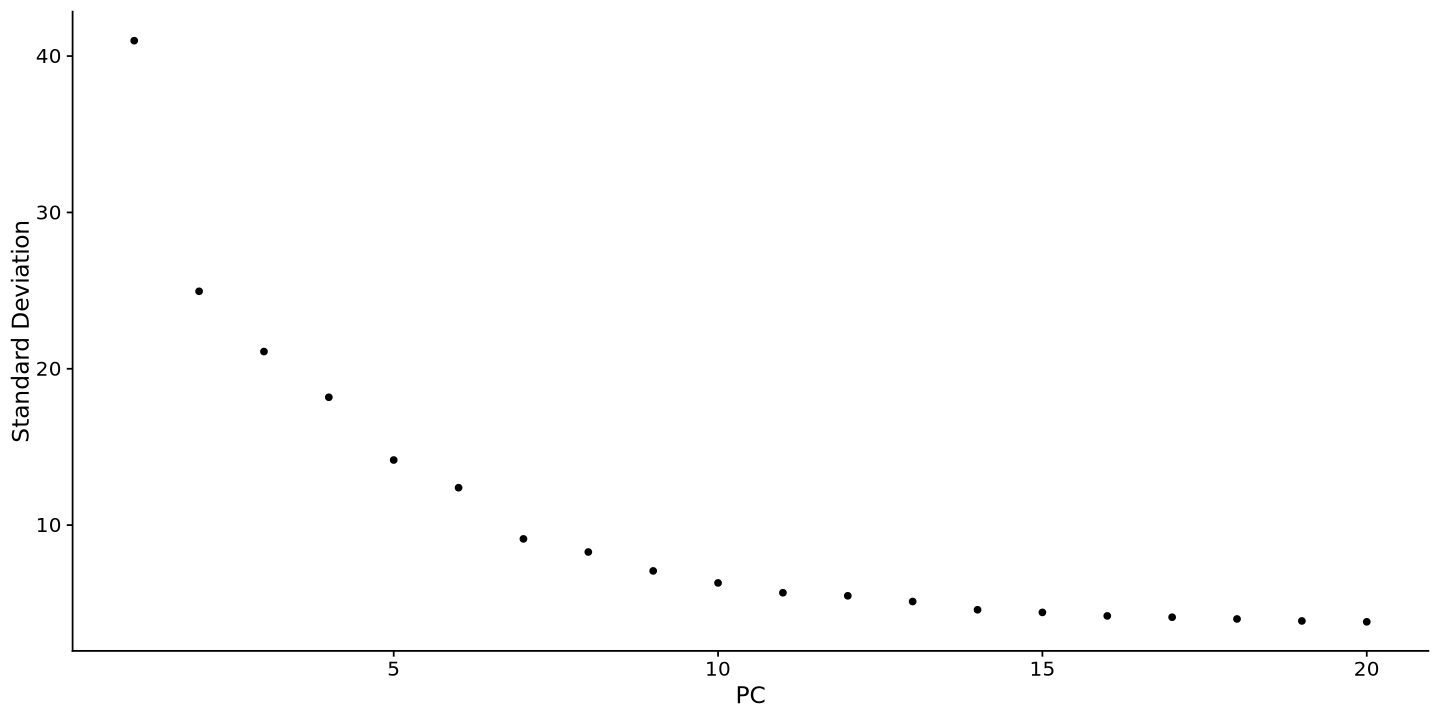

In [29]:
ElbowPlot(sample)

In [30]:
sample <- RunUMAP(sample, dims = 1:15)

14:59:41 UMAP embedding parameters a = 0.9922 b = 1.112

14:59:41 Read 3883 rows and found 15 numeric columns

14:59:41 Using Annoy for neighbor search, n_neighbors = 30

14:59:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:59:42 Writing NN index file to temp file /tmp/RtmphwjaOt/file1efcb66a5aeb3

14:59:42 Searching Annoy index using 1 thread, search_k = 3000

14:59:43 Annoy recall = 100%

14:59:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:59:46 Initializing from normalized Laplacian + noise (using RSpectra)

14:59:46 Commencing optimization for 500 epochs, with 147944 positive edges

14:59:49 Optimization finished



here it is. Similar to what we had before (this is very nice and unbiased data)

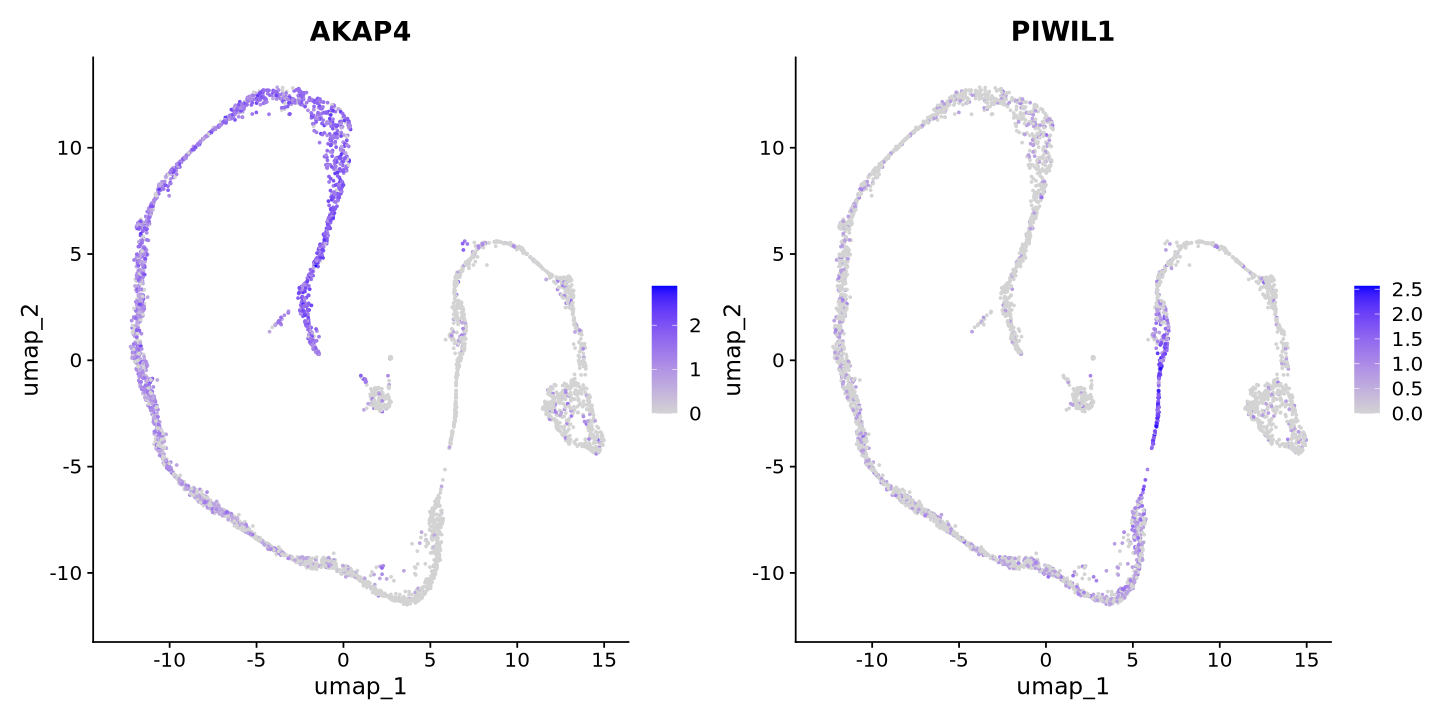

In [31]:
FeaturePlot(sample, reduction = "umap", features = c("AKAP4","PIWIL1"))

### Post-normalization Seurat object

Look at the seurat object now. You can see there is a new active assay, called `SCT` (as in `scTransform`). This is the new normalization. `counts` is the count matrix corrected for biases by the `SCTransform` statistical model, and `scale.data` is the scaled data. `data` is the corrected matrix `counts`, normalized but not scaled.

Note also that PCA and UMAP are saved in the assay.

In [32]:
sample

An object of class Seurat 
62987 features across 3883 samples within 2 assays 
Active assay: SCT (26386 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

You can also use slotNames to see an overview of the slots in the object. Try to look back at @fig-object to see how things match.

In [33]:
slotNames(sample@assays$SCT)

[1] "SCTModel.list" "counts"        "data"          "scale.data"   
[5] "assay.orig"    "var.features"  "meta.features" "misc"         
[9] "key"

## Clustering

Now we go straight into clustering. Now it is very popular to pull cluster labels from large cell atlases, but it is good to know how to do it manually by looking at markers. First of all we calculate cell similarities (neighbors) and a clustering. We choose a small resolution parameters to avoid a too fine-grained clustering inthe tutorial. Your clusters might be looking different than in this tutorial!

In [34]:
sample <- FindNeighbors(sample, dims = 1:15)
sample <- FindClusters(sample, resolution = 0.3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3883
Number of edges: 113438

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9486
Number of communities: 11
Elapsed time: 0 seconds


Notice how cluster numbers are now assigned to the `active.ident` assay, unused until now.

In [35]:
sample@active.ident[1:10]

AAACCTGAGCCTATGT-1 AAACCTGAGCTTTGGT-1 AAACCTGAGTACGCCC-1 AAACCTGAGTGAATTG-1 
                 6                  4                  7                  5 
AAACCTGCAGAGCCAA-1 AAACCTGGTAGGGTAC-1 AAACCTGGTCAGAAGC-1 AAACCTGGTCGTGGCT-1 
                 5                  0                  9                  3 
AAACCTGTCTCTGTCG-1 AAACGGGAGATGTGGC-1 
                 0                  4 
Levels: 0 1 2 3 4 5 6 7 8 9 10

You can plot the clusters as well on UMAP (or PCA)

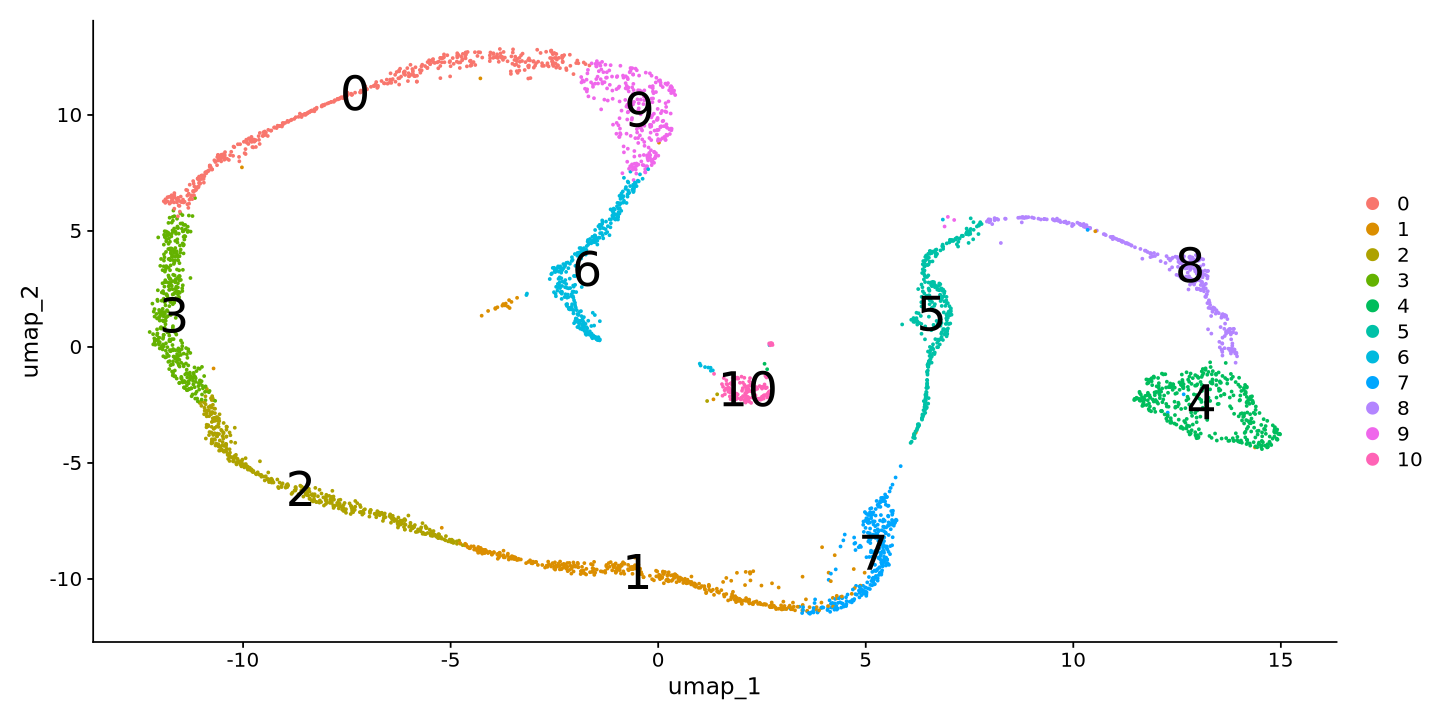

In [36]:
DimPlot(sample, reduction = 'umap', label=TRUE, label.size = 10)

Now let's look to some broad markers categories for spermatogenesis. This step requires biological knowledge of your data, and you can look at the literature or other resources to find the markers. For example, we can look at markers for spermatogonia, spermatocytes, and spermatids.

Spermatogonia Markers


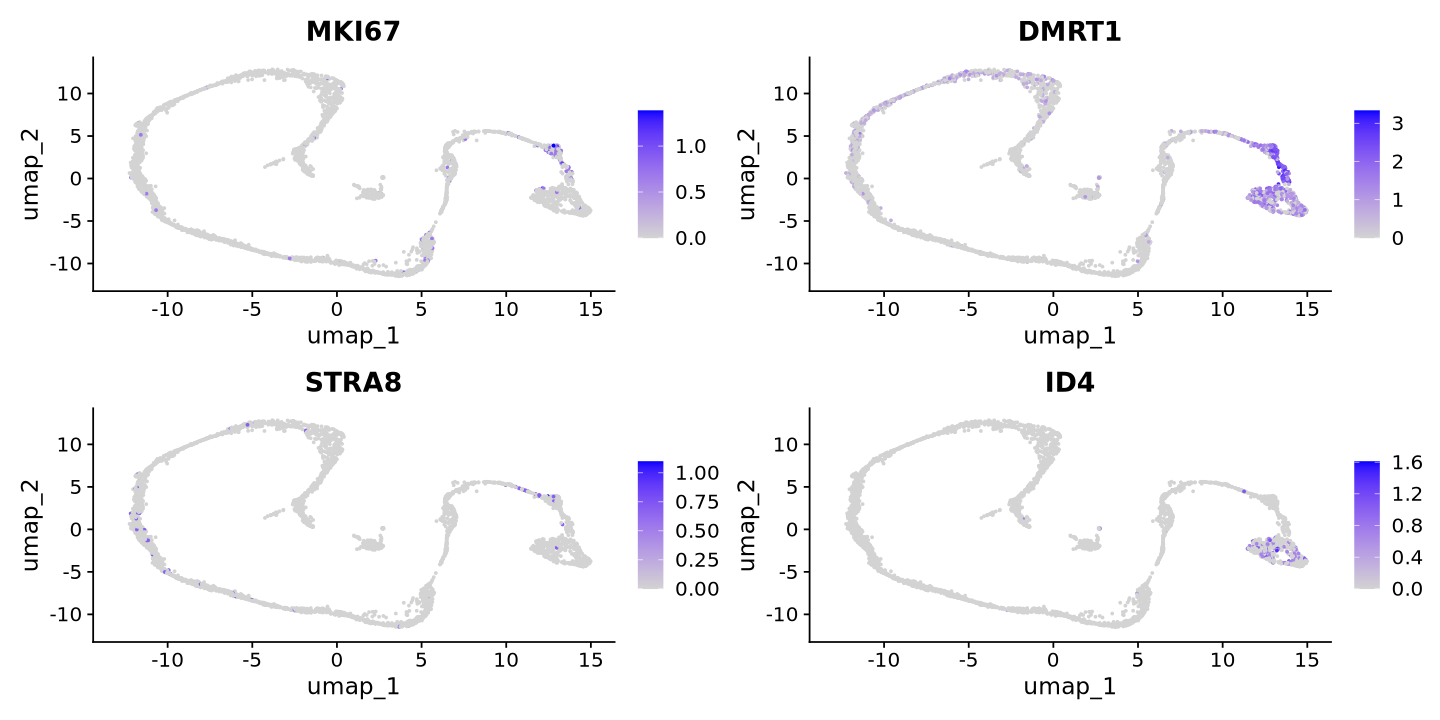

In [37]:
cat("Spermatogonia Markers\n")
FeaturePlot(sample, features = c('MKI67','DMRT1','STRA8','ID4'))

Spermatocytes Markers


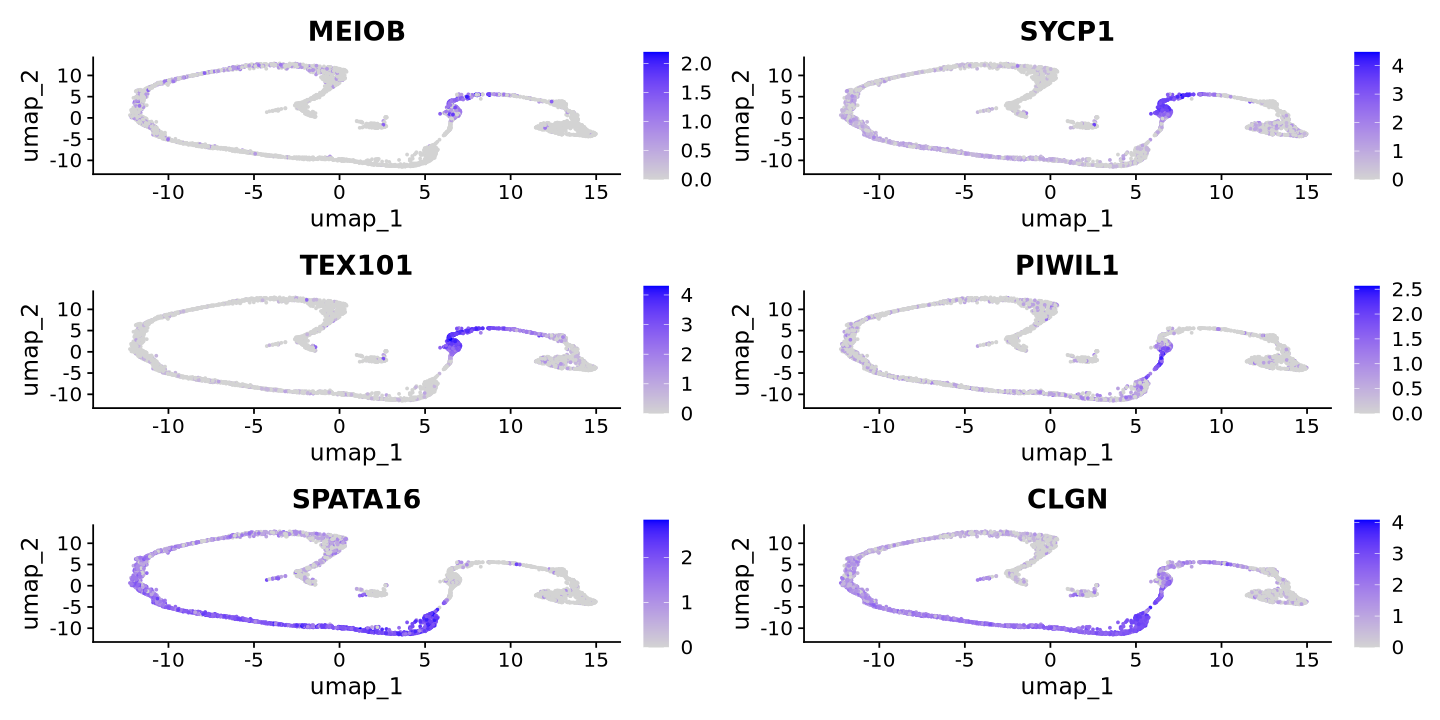

In [38]:
cat("Spermatocytes Markers\n")
FeaturePlot(sample, features = c('MEIOB','SYCP1','TEX101','PIWIL1','SPATA16','CLGN'))

Spermatid Markers


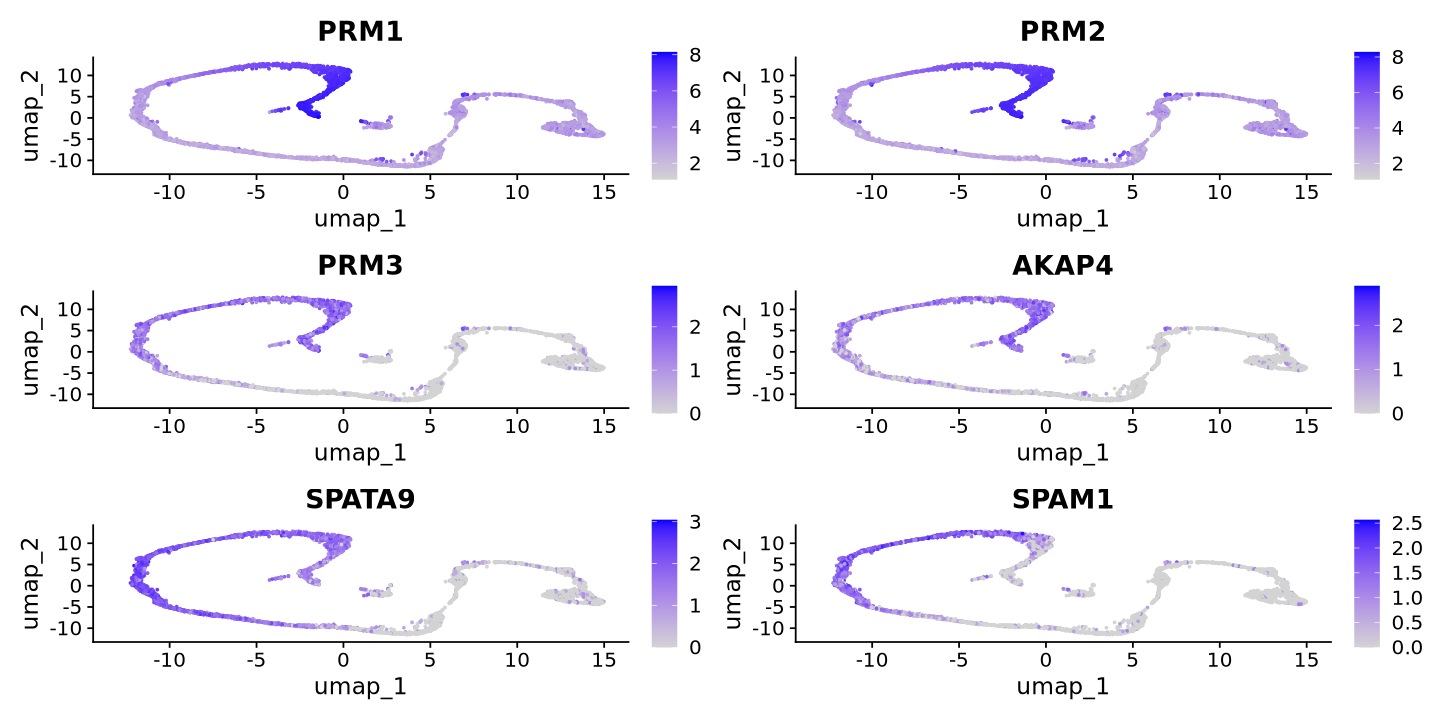

In [39]:
cat("Spermatid Markers\n")
FeaturePlot(sample, features = c('PRM1','PRM2','PRM3','AKAP4','SPATA9','SPAM1'))

We also look for some somatic markers

Somatic Markers


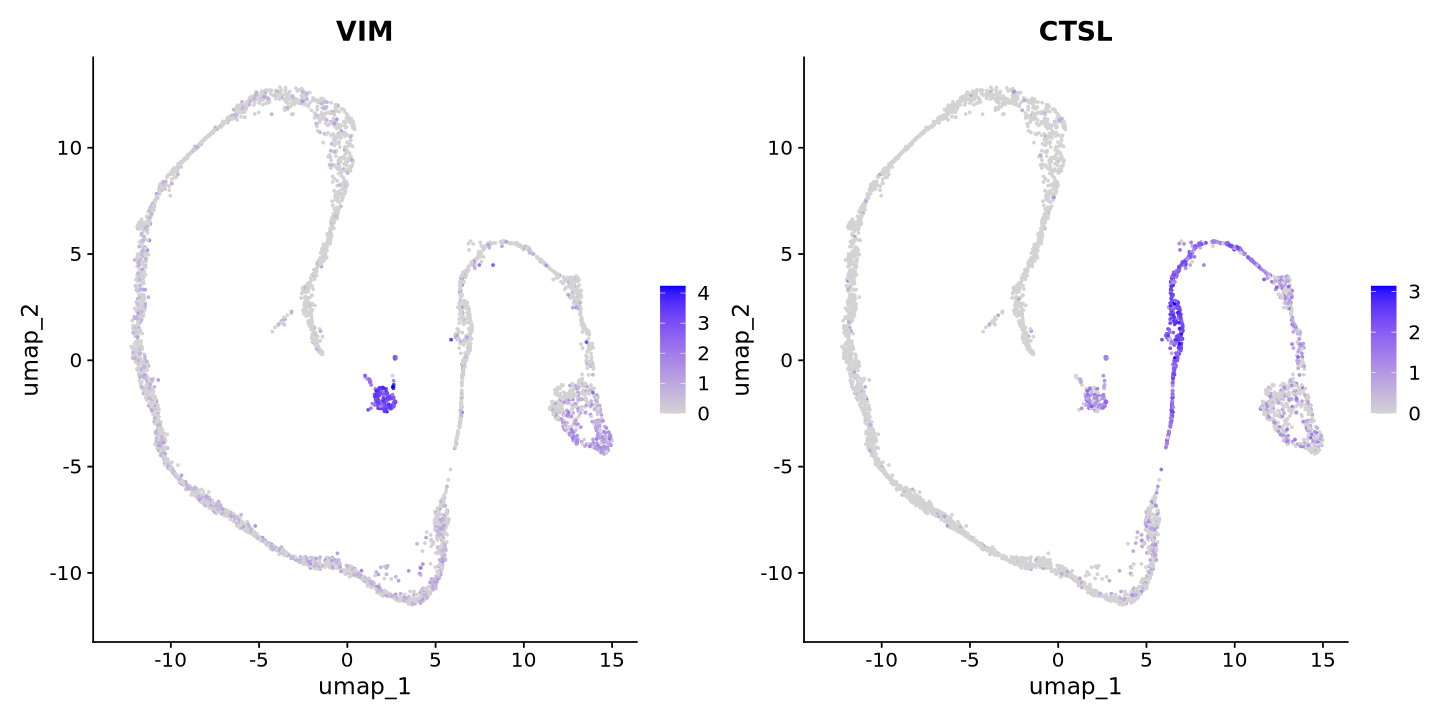

In [40]:
cat("Somatic Markers\n")
FeaturePlot(sample, features = c('VIM','CTSL'))

:::{.callout-tip}
Note how the somatic marker CTSL also ends where we might have another cell type. This happens often as there are markers involved in multiple biological processes! This is why it is important to look at multiple markers and not just one.
  
:::

### Renaming clusters

Now, we can choose to rename the clusters to more meaningful names. Simply create a named vector with the old and new names separated by `:`. 

:::{.callout-warning}
Fill out the example vector below yourself!
:::

In [41]:
new_names = c(
    '0'='clusterA',
    '1'='clusterB',
    '2'='clusterC')

Below, you substitute the cluster names with the new names. You can also use the `RenameIdents` function to rename the clusters.

In [43]:
sample@meta.data$new_clusters = recode(Idents(sample), !!!new_names)
sample@active.ident = as.factor(sample@meta.data$new_clusters)
names(sample@active.ident) = colnames(sample)

Now you are ready to look at your clustering!

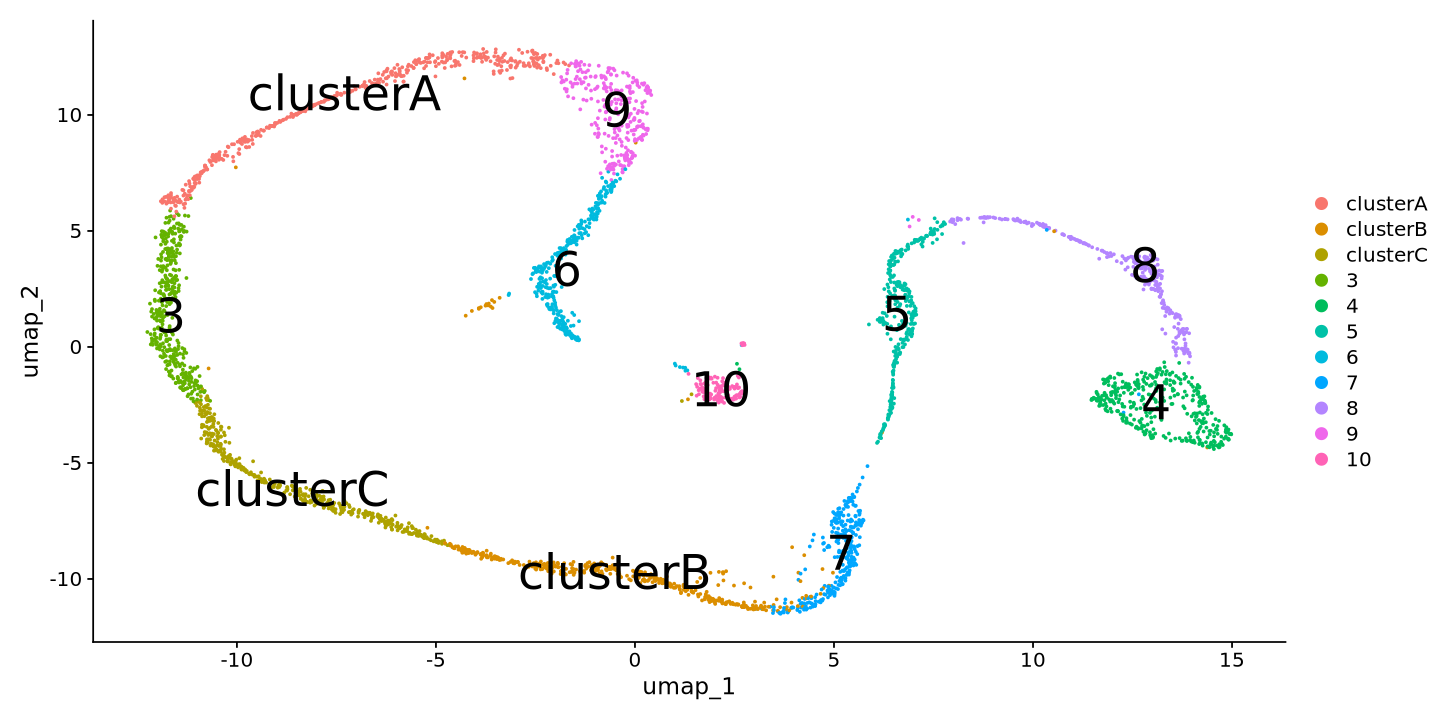

In [44]:
DimPlot(sample, reduction = 'umap', label=TRUE, label.size = 10)

:::{.callout-note}
Now you are ready to go on with your analysis. You can look at differential expression, cell cycle, and other analyses. Those will come in a second tutorial of the ABC, so keep your eyes on our [documentation](../Documentation.qmd).

In the meanwhile, you can try further tutorials on the Seurat website, or look at the [Seurat vignettes](https://satijalab.org/seurat/vignettes.html) for more advanced analyses.

We at the ABC also work with single cell analysis regularly, so do not hesitate to ask us for help!
:::